In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
link_groups = 'groups.csv'
link_groups_add = 'group_add.csv'
link_active_studs = 'active_studs.csv'
link_checks = 'checks.csv'

In [3]:
groups = pd.read_csv(link_groups, sep=';')
group_add = pd.read_csv(link_groups_add, sep=',')
active_studs = pd.read_csv(link_active_studs)
checks = pd.read_csv(link_checks, sep=';')

In [4]:
def count_metrics(base_dataframe, input_data, active_studs, checks):
    '''Функция для объединения DataFrame из разных источников и рассчета метрик

    Позволяет объединить два DataFrame: либо загрузив один из CSV файла
    по ссылке на файл, либо используя переданный объект DataFrame.
    Результатом является DataFrame, содержащий в себе рассчитанные метрики

    Параметры:
        base_dataframe (pandas.core.frame.DataFrame):
            исходный DataFrame, к которому будет присоеденены новые
            данные из input_data.
        input_data (str(link) or pandas.core.frame.DataFrame):
            Если str(link), то ссылка на файл CSV для загрузки DataFrame.
            Если объект DataFrame, то используется переданный DataFrame.
        active_studs (pandas.core.frame.DataFrame)
            Данные об активных пользователях, передается в DataFrame
        checks (pandas.core.frame.DataFrame)
            Данные о покупках пользователями, передается в DataFrame
        '''
    checks = checks.rename(columns={'student_id':'id'})
    active_studs = active_studs.rename(columns={'student_id':'id'})
    if isinstance(input_data, str):
        # Если входные данные - строка (ссылка на файл), загружаем DataFrame из CSV
        try:
            df_from_csv = pd.read_csv(get_ydisk_url(input_data), sep=',')
            result_df = pd.concat([base_dataframe,
                                   df_from_csv],
                                  ignore_index=True)
            result_df = (active_studs.merge(checks,
                                            on='id',
                                            how='left')
                                     .merge(result_df,
                                            on='id',
                                            how='left')
                                     .fillna(0))
            result_df['convert'] = result_df['rev'] != 0
            result_df = (
                            metrics_df.groupby('grp', as_index=False)
                                      .agg(paid_users=('convert', 'sum'),
                                           all_users=('id', 'count'),
                                           revenue=('rev', 'sum'))
                        )
            metrics = pd.DataFrame()
            metrics['Group'] = result_df.grp
            metrics['CR'] = round((result_df.paid_users
                                   / result_df.all_users)*100, 2)
            metrics['ARPU'] = round((result_df.revenue
                                     / result_df.all_users), 2)
            metrics['ARPPU'] = round((result_df.revenue
                                      / result_df.paid_users), 2)
            return metrics
        except:
            print("Ошибка при загрузке или обработке CSV файла.")
            return None
    elif isinstance(input_data, pd.core.frame.DataFrame):
        # Если входные данные - DataFrame, сразу конкатенируем
        result_df = pd.concat([base_dataframe,
                               input_data],
                              ignore_index=True)
        result_df = (active_studs.merge(checks,
                                        on='id',
                                        how='left')
                                     .merge(result_df,
                                            on='id',
                                            how='left')
                                     .fillna(0))
        result_df['convert'] = result_df['rev'] != 0
        result_df = (
                        result_df.groupby('grp',
                                          as_index=False)
                                 .agg(paid_users=('convert',
                                                  'sum'),
                                      all_users=('id',
                                                 'count'),
                                      revenue=('rev',
                                               'sum'))
                    )
        metrics = pd.DataFrame()
        metrics['Group'] = result_df.grp
        metrics['CR'] = round((result_df.paid_users
                               / result_df.all_users)*100, 2)
        metrics['ARPU'] = round((result_df.revenue
                                 / result_df.all_users), 2)
        metrics['ARPPU'] = round((result_df.revenue
                                  / result_df.paid_users), 2)
        return metrics
    else:
        print("Неподдерживаемый тип данных.")
        return None

In [5]:
df = count_metrics(groups, group_add, active_studs, checks)
df

,Group,CR,ARPU,ARPPU
0,A,5.07,47.35,933.59
1,B,4.62,58.06,1257.88


In [6]:
def graphics(data):
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    sns.barplot(x=data.Group,
                y=data.CR,
                ax=axes[0],
                palette='pastel')
    axes[0].set_title("CR",
                      fontsize=20)
    axes[0].set_ylabel('%',
                       fontsize='large',
                       rotation='horizontal',
                       labelpad=20)
    axes[0].set_xlabel('Group')
    sns.barplot(x=data.Group,
                y=data.ARPU,
                ax=axes[1],
                palette='husl')
    axes[1].set_title('ARPU',
                      fontsize=20)
    axes[1].set_ylabel('$',
                       fontsize='large',
                       rotation='horizontal',
                       labelpad=15)
    axes[1].set_xlabel('Group')
    sns.barplot(x=data.Group,
                y=data.ARPPU,
                ax=axes[2],
                palette='Spectral')
    axes[2].set_title('ARPPU',
                      fontsize=20)
    axes[2].set_ylabel('$',
                       fontsize='large',
                       rotation='horizontal',
                       labelpad=3)
    axes[2].set_xlabel('Group')
    plt.show()

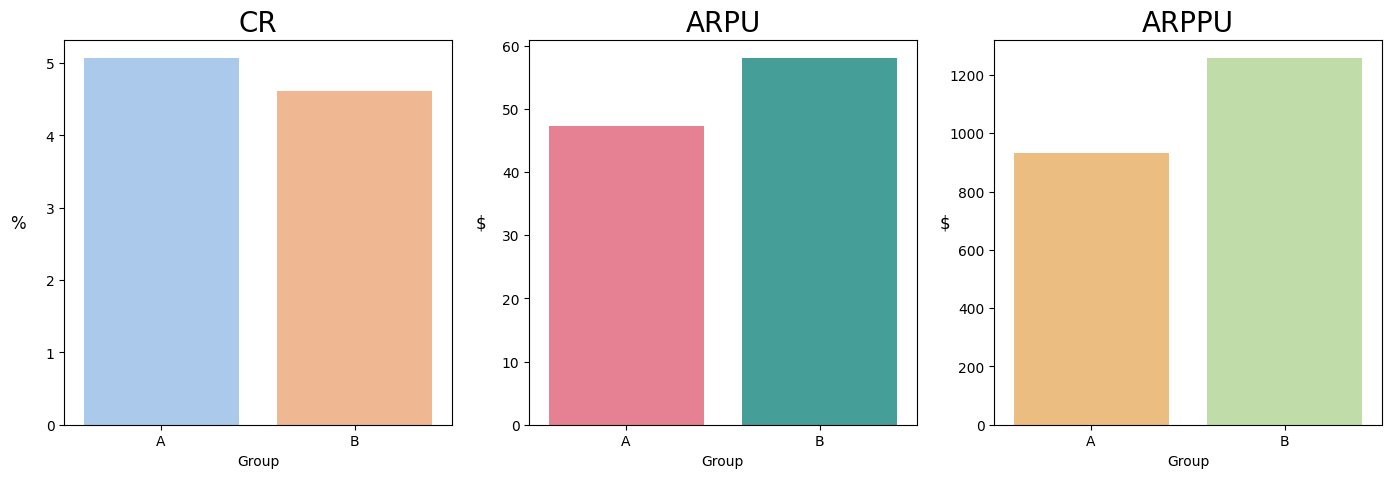

In [7]:
graphics(df)